### Imports

In [1]:
!pip3 install torch
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install screen-brightness-control
!pip install timeloop

In [2]:
import torch # PyTorch, charger le modèle
from matplotlib import pyplot as plt # Affichage statique des résultats
import numpy as np # Traitement des résultats
import cv2 # OpenCV, accès Webcam
import time
import screen_brightness_control as sbc # Changement de Luminosité
import os
from timeloop import Timeloop # Exécution périodique en arrière plan
from datetime import timedelta
from nightlight import * # Lumière Nocturne

### Import du modèle

In [3]:
model = torch.hub.load('ultralytics/yolov5','custom',path='best.pt',force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\cleme/.cache\torch\hub\master.zip
YOLOv5  2022-6-3 Python-3.9.7 torch-1.10.2 CPU

Fusing layers... 
Model summary: 213 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


### Affichage Webcam

In [4]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    results = model(frame)
    
    cv2.imshow('Test Drowsiness', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

image 1/1: 406x608 1 awake
Speed: 29.5ms pre-process, 102.0ms inference, 1.0ms NMS per image at shape (1, 3, 448, 640)


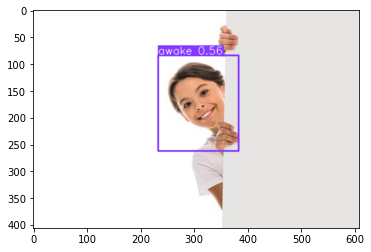

In [6]:
img = os.path.join('testawake.jpg')
results = model(img)
results.print()
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

### Situation Réelle Automatisée

In [7]:
tl = Timeloop()

@tl.job(interval=timedelta(seconds=5))
def tick():
    cap = cv2.VideoCapture(0)
    t = time.time()
    while cap.isOpened() and t-time.time() < 10:
        ret, frame = cap.read()

        results = model(frame)

        #cv2.imshow('Test Drowsiness', np.squeeze(results.render()))

        resultsDF = results.pandas().xyxy[0]
        drowsy_total = resultsDF[resultsDF["name"]=="drowsy"]["confidence"].sum()
        awake_total = resultsDF[resultsDF["name"]=="awake"]["confidence"].sum()

        if drowsy_total >= 3 * awake_total and drowsy_total>0.6:
            sbc.set_brightness('-30')
            write_NL_value(change_NL_value(get_NL_key(),whatdo="on"))
            print(f"DROWSY\t-\tDrowsy:{drowsy_total} | Awake:{awake_total}")
            break
        else : 
            print(f"AWAKE\t-\tDrowsy:{drowsy_total} | Awake:{awake_total}")
            write_NL_value(change_NL_value(get_NL_key(),whatdo="off"))
        break

    cap.release()
    cv2.destroyAllWindows()

In [8]:
tl.start(block=True)

[2022-06-03 14:47:10,837] [timeloop] [INFO] Starting Timeloop..


Starting Timeloop..


[2022-06-03 14:47:10,839] [timeloop] [INFO] Registered job <function tick at 0x000002444BDD8670>


Registered job <function tick at 0x000002444BDD8670>


[2022-06-03 14:47:10,839] [timeloop] [INFO] Timeloop now started. Jobs will run based on the interval set


Timeloop now started. Jobs will run based on the interval set


DROWSY	-	Drowsy:0.6263056397438049 | Awake:0.0
DROWSY	-	Drowsy:0.7644489407539368 | Awake:0.0
[2022-06-03 14:47:34,988] [timeloop] [INFO] Stopping job <function tick at 0x000002444BDD8670>


Stopping job <function tick at 0x000002444BDD8670>


[2022-06-03 14:47:34,989] [timeloop] [INFO] Timeloop exited.


Timeloop exited.
